In [1]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
# from RKHS import SparseVFC
# from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix

import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD

from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

import seaborn as sns
from scipy.stats import gaussian_kde

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())

data_path = 'data/'
data_name = 'DG_bin'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
# data_name = 'zebrafish_dynamo_part'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
#adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
pca_dim = 50
[k_nei, K, L] = [20, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'
method = ''

result_path = 'DTW_action_results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = result_path
cmap = plt.colormaps['Spectral']

import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

d:\Anaconda\envs\pytorch\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
d:\Anaconda\envs\pytorch\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
d:\Anaconda\envs\pytorch\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
d:\Anaconda\envs\pytorch\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
d:\Anaconda\envs\pytorch\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, Fu

2.3.0
None
False
0


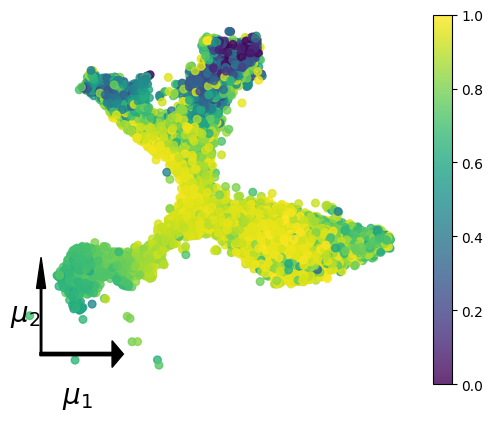

In [2]:
data_path='data/'
#data_name = 'BoneMarrow/human_cd34_bone_marrow.h5ad'
#data_name = 'EG_ab_dyn.h5ad'
data_name = '20DG_data.h5ad'
#data_name = 'processed bonemarrow.h5ad'
#data_name = 'lung.h5ad'
#data_name = 'DentateGyrus/DentateGyrus.loom'
adata0=scv.read(data_path+data_name, cache=True)

#model_name = 'EG_ab_dyn'
#model_name = 'processed bonemarrow'
#model_name = 'lung'
model_name = 'DentateGyrus'

subfolder = 'weighted'
result_path = 'results/'+model_name+'/'+subfolder+'/'

k_nei = 20
# #-------data preprocessing
# while True:

#     #adata=adata0.copy()
#     scv.pp.neighbors(adata0, n_neighbors=k_nei)
#     scv.pp.moments(adata0, n_pcs=50, n_neighbors=k_nei)
#     zero_gene_num = np.sum(np.sum(adata0.layers['Ms'],axis=0) == 0)
#     print('zero_gene_num',zero_gene_num)
#     if zero_gene_num == 0:
#         lowvar_num = np.sum(np.var(adata0.layers['Ms'],0)<1e-1)
#         print('lowvar_num',lowvar_num)
#         if lowvar_num == 0:
#             break
#         else:
#             adata0 = adata0[:,(np.var(adata0.layers['Ms'],0)>1e-1)]
#     else:
#         adata0 = adata0[:,(np.sum(adata0.layers['Ms'],axis=0) != 0)]

# scv.pp.pca(adata0,n_comps=50)

# scv.tl.velocity(adata0)
# scv.tl.velocity_graph(adata0)
# scv.tl.velocity_pseudotime(adata0)

 ###读存储数据
K,L = 3,6
read_path = 'results/'+model_name+'/'+f'weighted/k_nei={k_nei}/'#+ f'k_nei={k_nei}/'
para = f'K={K} L={L}/'
para = ''
Xs = np.load(read_path+'X'+'.npy')
X_pca = np.load(read_path+'X_pca'+'.npy')
cell_nei = np.load(read_path+'cell_nei'+'.npy')
nei_w = np.load(read_path+'nei_w'+'.npy')
color_label = np.load(read_path+'color_label'+'.npy')
encoder = torch.load(read_path+para+'encoder'+'.pt')
Fisher_g = np.load(read_path+para+'Fisher_g'+'.npy')
crc_smooth = np.load(read_path+para+'crc_smooth'+'.npy')
crc_eu = np.load(read_path+para+'crc_eu'+'.npy')
k_nei=cell_nei.shape[1]
n = Xs.shape[0]

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def Fisher_dist_new(mu1, sigma1, mu2, sigma2):
    dmu = (mu1 - mu2) / np.sqrt(2)
    sigma_sum = sigma1 + sigma2
    sigma_diff = sigma1 - sigma2
    
    a = np.sqrt(dmu**2 + sigma_sum**2) + np.sqrt(dmu**2 + sigma_diff**2)
    b = np.sqrt(dmu**2 + sigma_sum**2) - np.sqrt(dmu**2 + sigma_diff**2)
    
    dF2 = 2 * np.sum(np.log(a / b)**2)
    return np.sqrt(dF2)

def wasserstein_distance_new(mu1, sigma1, mu2, sigma2):
    dmu = mu1 - mu2
    W_dist2 = np.sum(dmu**2 + sigma1**2 + sigma2**2 - 2 * np.sqrt(sigma2 * sigma1**2 * sigma2))
    return np.sqrt(W_dist2)

def Jacobian_nn_new(x0, encoder):
    x = torch.tensor(x0, requires_grad=True)
    
    # Compute the Jacobian for both outputs in the encoder
    def compute_jacobian(x):
        z = encoder(x)
        return torch.cat((z[0], z[1]))

    jacobian = torch.autograd.functional.jacobian(compute_jacobian, x)
    
    # Split the jacobian into two parts
    d = jacobian.shape[0] // 2
    pMu_pX = jacobian[:d]
    pSgm_pX = jacobian[d:]
    
    return pMu_pX.numpy(), pSgm_pX.numpy()


###############读数据
K,L = 3,6
read_path = 'results/'+model_name+'/'+'weighted/'+ f'k_nei={k_nei}/'
para = ''#f'K={K} L={L}/'
Xs = np.load(read_path+'X'+'.npy')
X_pca = np.load(read_path+'X_pca'+'.npy')
cell_nei = np.load(read_path+'cell_nei'+'.npy')
nei_w = np.load(read_path+'nei_w'+'.npy')
color_label = np.load(read_path+'color_label'+'.npy')
encoder = torch.load(read_path+para+'encoder'+'.pt')
Fisher_g = np.load(read_path+para+'Fisher_g'+'.npy')
crc_smooth = np.load(read_path+para+'crc_smooth'+'.npy')
crc_eu = np.load(read_path+para+'crc_eu'+'.npy')
cell_vpt=color_label
X=Xs

###读存储数据numpy版本导致clusters读取失败运行这段代码
np.load.__defaults__ =(None, True, True, 'ASCII')
clusters = np.load(read_path+'clusters'+'.npy')
clusters_PAGA = np.load(read_path+'clusters_PAGA'+'.npy')
gene_arr = np.load(read_path+para+'gene_arr'+'.npy')
np.load.__defaults__ =(None, False, True, 'ASCII')

###读存储数据
X_plt = np.load(read_path+'X_plt'+'.npy')
Y_plt = np.load(read_path+'Y_plt'+'.npy')
##坐标 和 伪时间图

X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min+5*wid
Y_ori = Y_min+5*wid

plt.scatter(X_plt,Y_plt,s=30,alpha=0.8,c=color_label,cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid*1.5,color='black',head_width=12*wid,head_length=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid*2/3,color='black',head_width=4*wid,head_length=14*wid)

plt.text(X_ori+X_len/2,Y_ori-wid*22,'$\mu_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*7,Y_ori+Y_len/2,'$\mu_2$',fontsize=20,ha='center',weight='bold')

# plt.savefig(result_path+model_name+'_mu.png',dpi=600,bbox_inches='tight')
plt.show()

In [3]:
#######要跑
adata=adata0.copy()
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
velo_pca = velo_g@adata.varm['PCs']
#latent_z = np.hstack((mu_learned,sigma_learned))

In [4]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
latent_z = np.hstack((mu_learned,sigma_learned))

In [5]:

cl_name = np.unique(clusters)
palette = sns.color_palette("RdBu_r",n_colors=cl_name.shape[0])
# palette = sns.color_palette(n_colors=cl_name.shape[0])
cln = np.array(clusters)
cl_vpt = np.zeros(cl_name.shape[0])
for i in range(cl_name.shape[0]):
    if data_name=='DG_bin':
        cl_vpt[i] = np.mean(cell_vpt[cln==cl_name[i]])
    else:
        cl_vpt[i] = np.mean(cell_vpt[cln==cl_name[i]])
cl_vpt_ind = np.argsort(cl_vpt)
cl_name_vpt = cl_name[cl_vpt_ind]

cln_vpt_ind = np.zeros(cln.shape[0],dtype=int)
clx = np.zeros(cln.shape[0])
clc = np.array([palette[0]]*cln.shape[0])
cl_ind = np.zeros(cl_name.shape[0])
i_ind = 0
for i in range(cl_name.shape[0]):
    cli_ind = np.argwhere(cln==cl_name_vpt[i])[:,0]
    ni = cli_ind.shape[0]
    cln_vpt_ind[i_ind:i_ind+ni] = cli_ind
    clx[cli_ind] = i
    clc[cli_ind] = palette[i]
    cl_ind[i] = i_ind+ni/2
    i_ind += ni
cln_vpt = cln[cln_vpt_ind]

In [6]:
from utils import *
velo = np.load(read_path+'velocity'+'.npy')

In [7]:
pMu_pX = np.zeros([X.shape[0],L,X.shape[1]])
pSgm_pX = np.zeros([X.shape[0],L,X.shape[1]])
for i in range(X.shape[0]):
    pMu_pX[i],pSgm_pX[i] = Jacobian_nn(X[i],L,encoder)
    #pMu_pX[i],pSgm_pX[i] = Jacobian_nn_new(X[i],L,encoder)
mu_velo = np.array([pMu_pX[i]@velo[i] for i in range(X.shape[0])])
sgm_velo = np.array([pSgm_pX[i]@velo[i] for i in range(X.shape[0])])
zv2 = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    for j in range(L):
        zv2[i] += Fisher_g[i,j,j]*mu_velo[i,j]**2 + Fisher_g[i,L+j,L+j]*sgm_velo[i,j]**2
zv1 = np.sqrt(zv2)
zv1_smooth = smooth_func(zv1)

In [8]:
# #-------------transcription factors analysis
# df = pd.read_csv(data_path+'gene lists/mouse_TF_list.csv')
# TF = df['Symbol'].values
# adata=adata0.copy()
# for ti in range(len(TF)):
#     TF[ti] = TF[ti].upper()
# gene_list = np.array([x.upper() for x in adata.var.index.values])
# tf_inds = np.where(np.in1d(gene_list,TF))[0]
# non_tf_inds = np.where(~np.in1d(gene_list,TF))[0]
# tf_gene = adata.var.index.values[tf_inds]
# print(len(tf_inds))

In [9]:
###gene FI and stiff gene
stiffnum = np.zeros(X.shape[0])##number of stiffgene |(n,1)
# tf_stiffnum = np.zeros(X.shape[0])
pZ_pX = np.zeros([X.shape[0], L*2, X.shape[1]])
diagFIgene = np.zeros((X.shape[0],X.shape[1])) ##FI of gene |(n,m)
Eigenvec = np.zeros((X.shape[0],X.shape[1]))   ##1st eigenvec for each cell |(n,m)
for i in range(X.shape[0]):
    pZ_pX[i] = np.vstack((pMu_pX[i],pSgm_pX[i]))
    FIgene_i = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]
    Eigenvec[i] = np.linalg.eigh(FIgene_i)[1][:,-1]
    diagFIgene[i] = np.diag(FIgene_i)
    FI_max = np.array([np.argmax(FIgene_i[j]) for j in range(X.shape[1])])
    # tf_max = np.array([np.argmax(FIgene_i[tf_inds][:,tf_inds][j]) for j in range(len(tf_inds))])
    stiffnum[i] = len(np.unique(list(FI_max)))
    # tf_stiffnum[i] = len(np.unique(list(tf_max)))

In [10]:
Eigenvec.shape

(14366, 845)

In [11]:
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)

Eigen gene direction

In [22]:
categories = np.unique(clusters)
eigenvec={}
for i in categories:
    eigenvec[i] = Eigenvec[clusters==i]

In [23]:
for i in categories:
    print(i,len(Eigenvec[clusters==i]))

CA 2298
CA1-Sub 1664
CA2-3-4 2129
Granule 863
ImmGranule1 2460
ImmGranule2 2099
Nbl1 419
Nbl2 1003
RadialGlia 1043
RadialGlia2 388


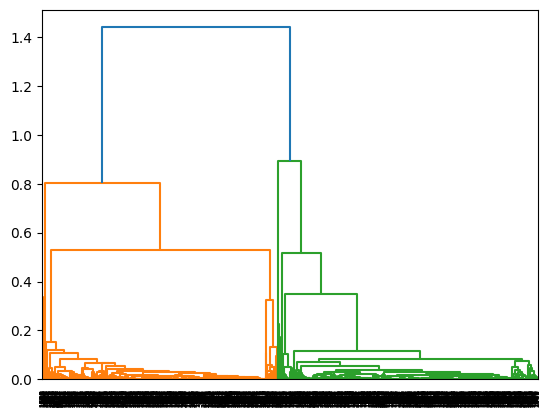

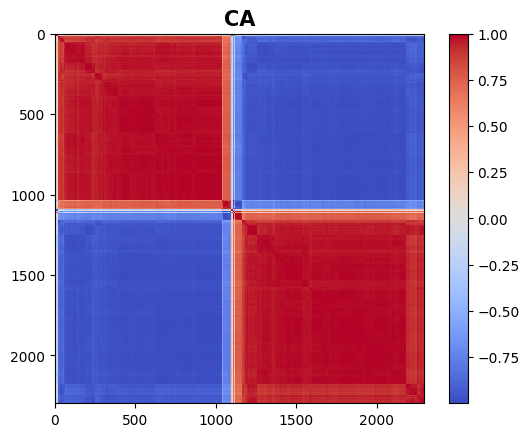

[2 1 2 ... 1 2 1]


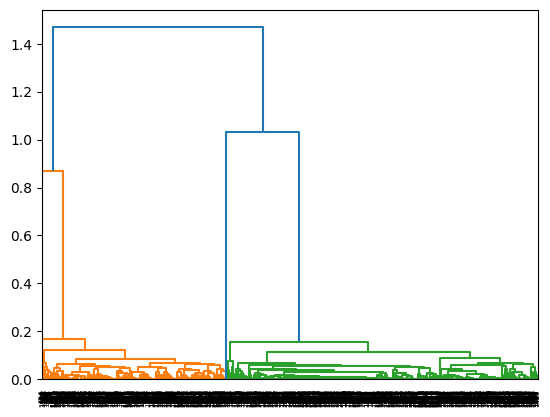

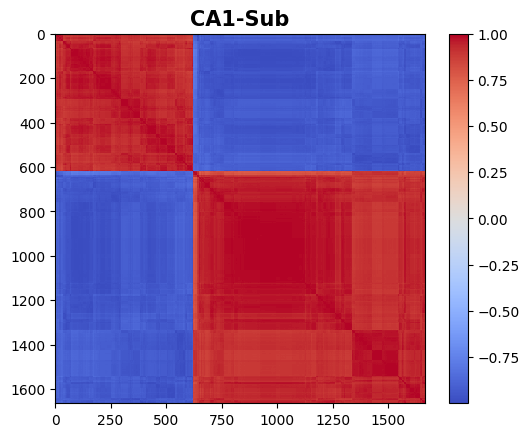

[2 1 1 ... 2 2 2]


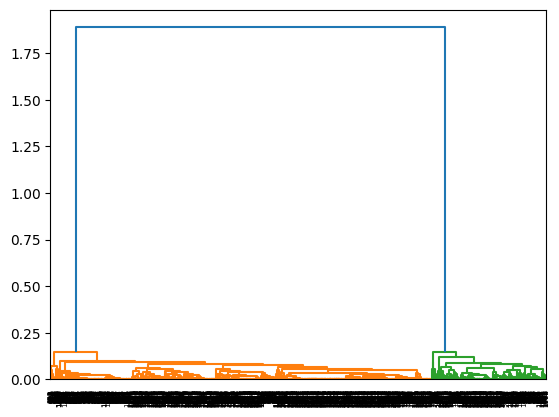

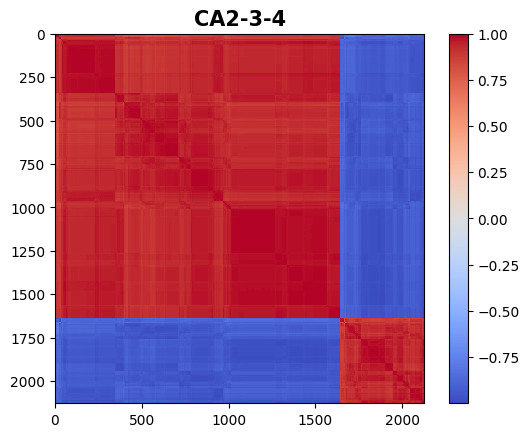

[1 1 2 ... 2 1 1]


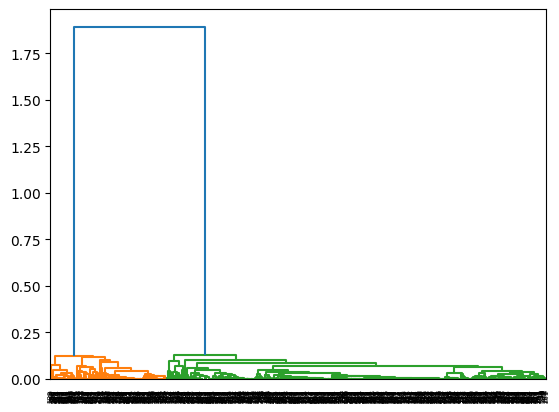

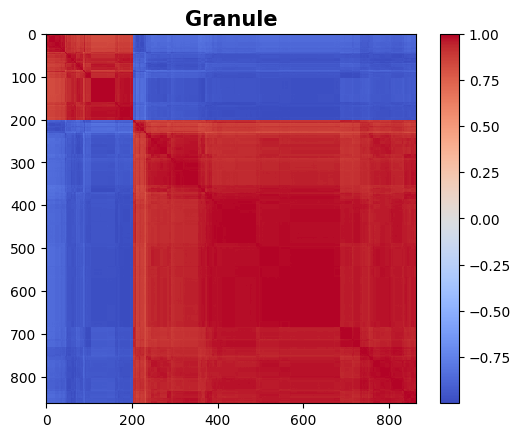

[2 1 1 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 1 2 2 2 2 2 2 1
 2 2 2 1 1 2 1 2 2 2 1 2 1 2 2 1 2 2 2 1 2 2 2 1 1 1 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 2 1 1 2 2 2 2 2 2 2 1 1 2 2 2 1 1 2 2 1
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 2 2 2 2 2 1 1 2 2 2 1 2 1 2 1 2 1 2 1 2 2 2 2 2 2 1 2 1 2 1 2 2
 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 1 2 1 1 1 2 2
 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 1 2 1 1 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2
 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2
 2 1 2 2 2 2 1 2 1 1 2 1 1 1 2 1 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 1 1 2 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 1 2 1 2 1 1 1 1 2 2 2 2 2 2 1 2
 2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 1 1 2 2 2 2 1 2 2 2 2 2 1
 2 1 2 2 2 2 2 2 2 2 2 2 

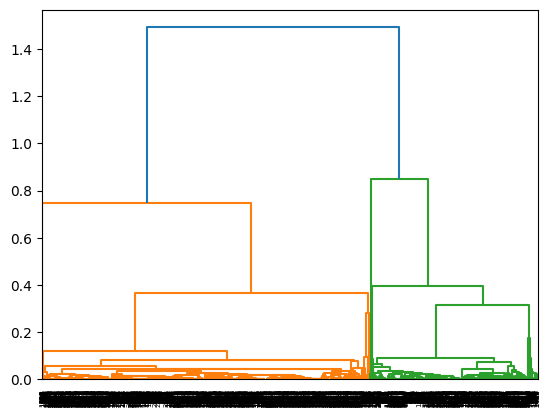

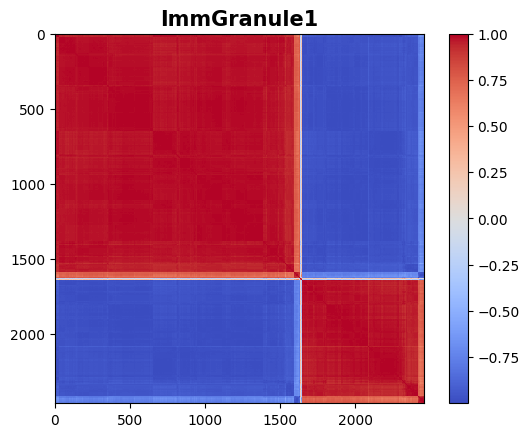

[2 1 2 ... 1 1 1]


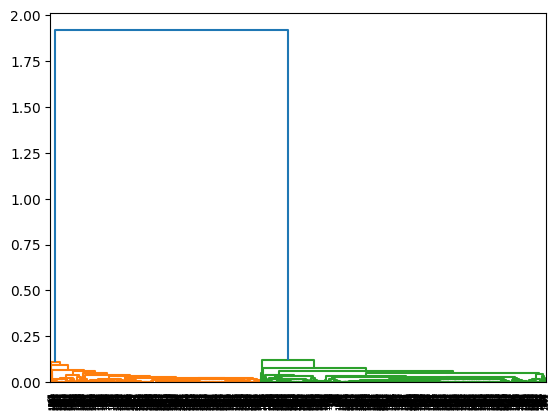

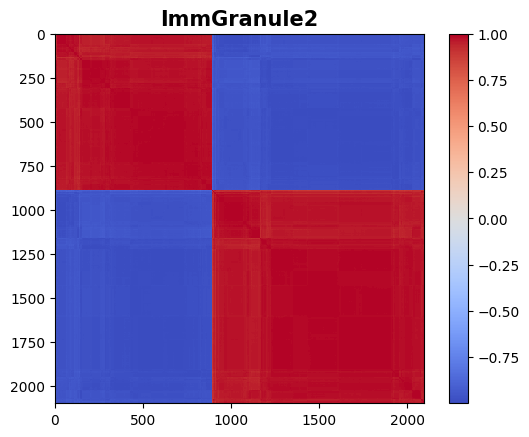

[1 2 2 ... 2 1 1]


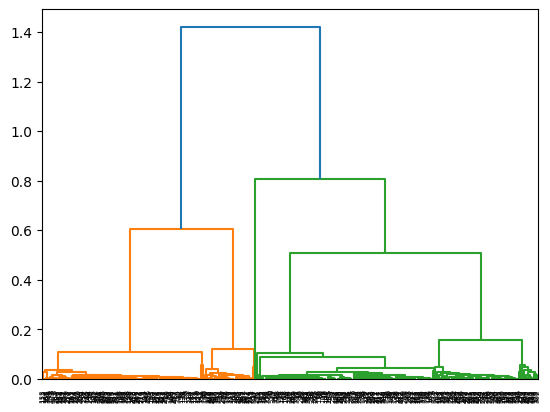

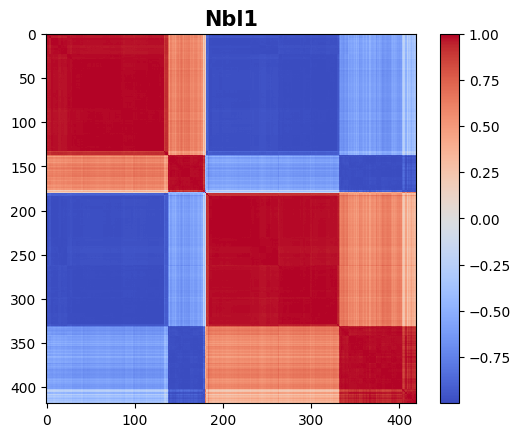

[2 1 2 1 2 1 2 2 1 1 1 1 1 1 1 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2 2
 1 2 2 2 1 2 2 2 1 1 2 1 1 2 1 1 2 1 2 2 2 2 2 2 1 1 2 1 1 2 2 1 2 2 1 1 2
 2 1 1 2 1 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 1 2 2 1 1 1 2 2 1 2 2 2 1 1
 1 2 2 1 1 2 2 1 2 1 1 2 1 1 1 2 2 2 1 1 2 1 1 1 1 1 2 2 1 2 1 2 1 2 1 2 1
 1 2 2 1 2 1 1 1 2 1 1 2 1 2 2 1 1 1 2 1 2 2 1 1 2 2 1 2 2 2 1 1 1 1 1 2 2
 2 2 1 1 1 1 2 1 1 2 2 2 1 2 2 2 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 1 2 1 1 2
 2 1 2 2 2 1 2 2 2 1 1 2 2 1 1 1 1 2 2 1 1 2 2 1 2 2 1 2 2 1 2 1 1 1 2 1 2
 1 2 2 2 2 1 2 2 2 2 2 1 1 2 1 1 2 2 1 2 2 2 1 2 2 2 1 2 1 2 1 1 2 2 2 2 2
 1 2 2 1 1 1 2 1 1 1 2 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 2 2 2 1 2 2
 1 2 2 1 1 1 2 2 2 1 1 1 2 1 1 2 2 2 1 1 2 2 1 2 1 1 2 1 1 2 2 2 2 2 2 1 1
 2 2 1 1 2 1 2 2 1 1 2 2 2 2 1 2 2 1 2 2 2 2 2 2 1 2 2 1 1 1 1 2 2 1 2 1 1
 1 2 2 1 1 1 1 2 2 1 1 2]


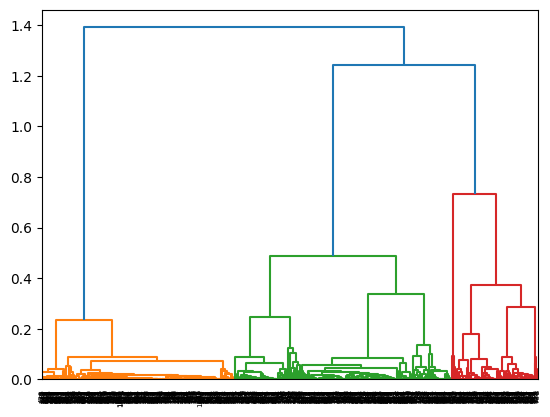

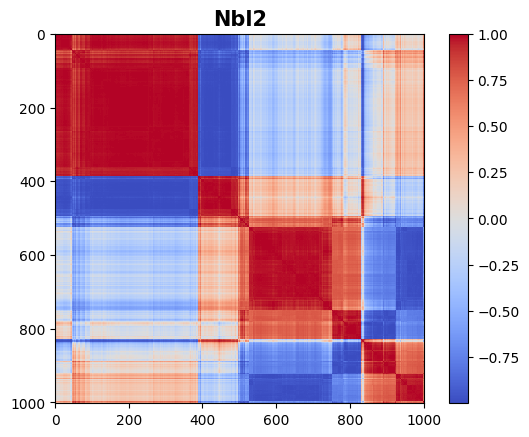

[2 2 3 ... 1 1 1]


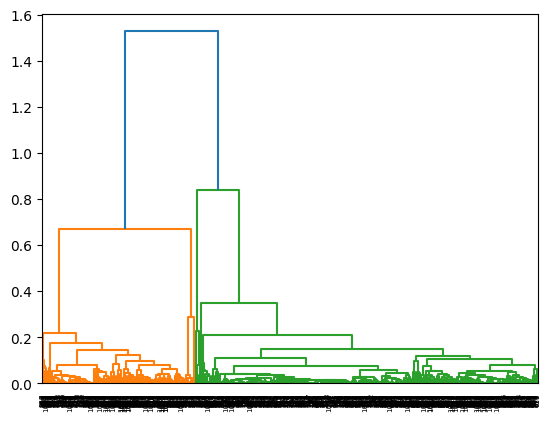

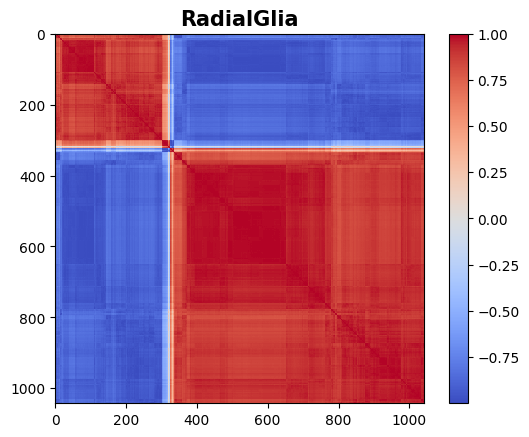

[1 1 2 ... 2 1 2]


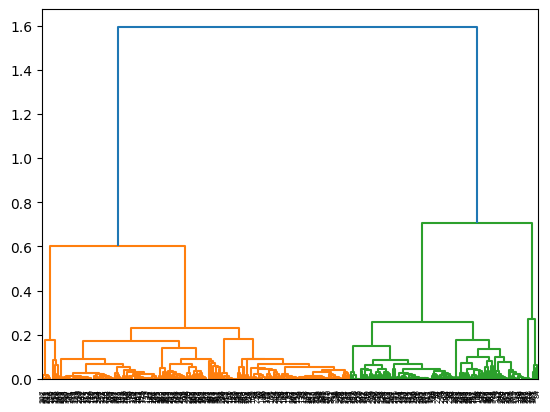

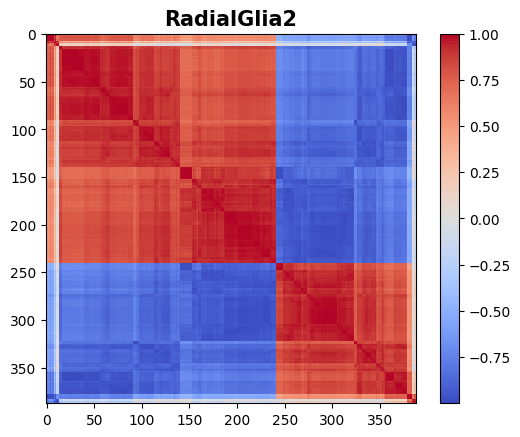

[1 1 1 1 2 2 1 2 2 2 2 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 2
 1 1 1 2 1 2 2 2 1 2 1 1 1 1 1 1 2 2 1 1 1 1 2 2 2 1 1 2 2 2 1 1 2 1 2 1 1
 2 1 2 2 2 2 1 1 2 1 2 1 1 1 1 1 2 2 1 2 2 1 2 2 2 2 1 1 1 1 1 2 1 1 1 2 1
 1 1 1 1 1 1 2 2 1 2 1 1 2 2 2 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 1
 2 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 1
 1 2 1 2 2 1 2 2 1 1 2 1 2 1 1 1 1 2 1 1 2 2 2 1 1 2 2 1 2 2 2 1 1 1 1 1 1
 2 2 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 2 1 2 1 1 1 2 2 1 1 2 2 2 1 2
 1 2 1 1 2 1 1 1 2 2 1 2 1 1 2 2 1 1 2 1 2 1 1 2 1 2 1 1 2 2 2 2 2 2 1 2 1
 1 2 2 1 1 2 1 1 2 1 2 1 2 1 1 2 1 1 1 1 1 2 2 1 1 1 2 2 2 1 1 2 1 1 2 1 1
 2 2 1 2 2 2 1 1 2 1 2 1 1 2 2 2 2 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1 2 2 1 2 2
 1 1 2 1 1 1 2 2 2 1 2 1 2 1 1 1 1 1]


In [ ]:
###Before optimize the cosdistance

for i in range(len(categories)):
    cl_cat = categories[i]
    vec_corr = eigenvec[cl_cat]@eigenvec[cl_cat].T
    
    Z=linkage((1-vec_corr)[np.triu_indices(vec_corr.shape[0],k=1)],method='weighted')#method='weighted')
    dg=dendrogram(Z)
    #X_re= X[:,dg['leaves']]#X_re reorder X by clustering
    plt.show()
    
    vec_corr_re = vec_corr[dg['leaves'],:][:,dg['leaves']]
    plt.imshow(vec_corr_re, aspect='equal', cmap=plt.cm.coolwarm, interpolation='nearest')
    plt.title(categories[i],fontsize=15,weight='bold')
    plt.colorbar()
    plt.savefig(result_path+f'Corr of {categories[i]}.png')
    plt.show()

    # xcos = np.linspace(0,1,100)
    # plt.plot(xcos,gaussian_kde(vec_corr.flatten())(xcos))
    # plt.title(categories[i],fontsize=15,weight='bold')
    # plt.show()
    
    T = fcluster(Z, t=0.9, criterion='distance')
    print(T)

In [17]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
def GRBopt(Eigenvec):
    n = len(Eigenvec)
    np.random.seed(42)
    X = Eigenvec@Eigenvec.T
    # Create model
    m = gp.Model("binary_quadratic")

    # Create binary variables (will be transformed to {-1,1})
    b = m.addVars(n, vtype=GRB.BINARY, name="b")

    # Set objective: min sum_{i,j} c_i c_j x_{ij}
    # where c_i = 2b_i - 1 transforms binary variables to {-1,1}
    obj = gp.QuadExpr()
    for i in range(n):
        for j in range(n):
            # Expand (2b_i - 1)(2b_j - 1)x_{ij}
            obj += -4 * X[i,j] * b[i] * b[j]  # quadratic term
            obj += 2 * X[i,j] * b[i]        # linear terms
            obj += 2 * X[i,j] * b[j]
            obj += -X[i,j]                    # constant term

    m.setObjective(obj, GRB.MINIMIZE)

    # Optimize
    m.optimize()

    # Extract solution
    if m.status == GRB.OPTIMAL:
        # Convert binary solution back to {-1,1}
        c = [2 * b[i].x - 1 for i in range(n)]
        print("Optimal solution found:")
        print("c =", c)
        print("Objective value =", m.objVal)
        return c
    else:
        print("No optimal solution found")


In [27]:
(np.diag(c)@Eigenvec[clusters=='CA']).shape

(2298, 845)

In [29]:
eigenvec={}
for i in categories:
    c = GRBopt(Eigenvec[clusters == i])
    eigenvec[i] = np.diag(c)@Eigenvec[clusters==i]

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 9600X 6-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 2298 columns and 0 nonzeros
Model fingerprint: 0x20cd75e7
Model has 2641551 quadratic objective terms
Variable types: 0 continuous, 2298 integer (2298 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+01, 5e+02]
  QObjective range [3e-05, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -13955.71322
Found heuristic solution: objective -13955.71322
Found heuristic solution: objective -4855895.962
Presolve time: 3.30s
Presolved: 0 rows, 2298 columns, 0 nonzeros
Presolved model has 2639253 quadratic objective terms
Variable types: 0 continuous, 2298 integer (2298 binary)

Root simplex log...

Iteration    Objective  

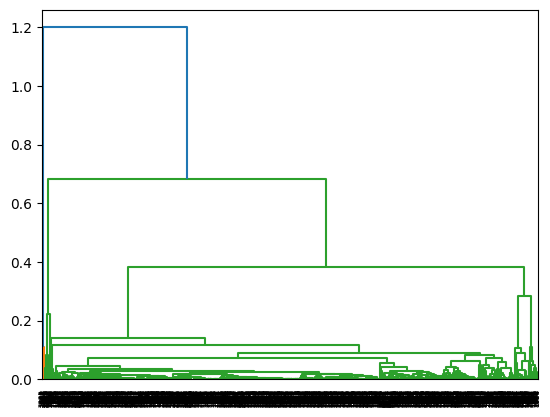

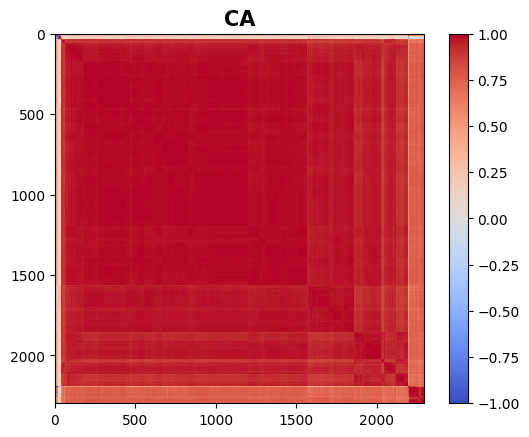

[3 3 3 ... 3 3 3]


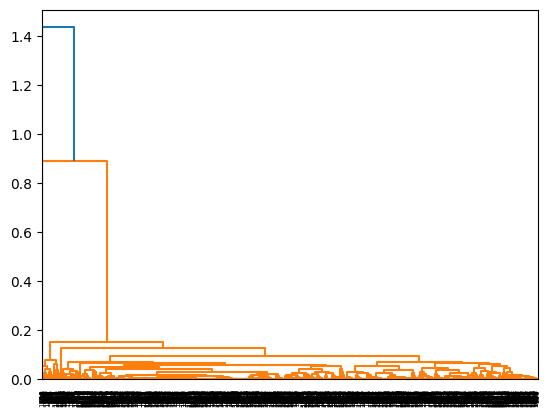

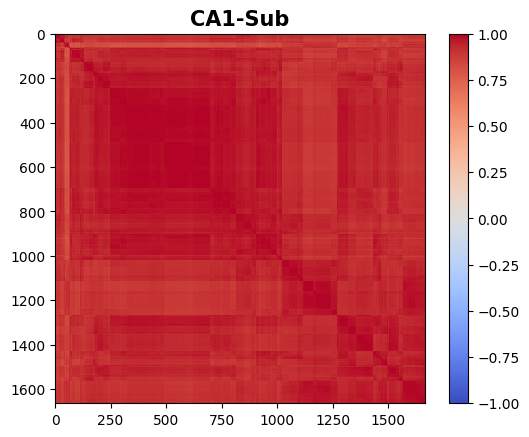

[1 1 1 ... 1 1 1]


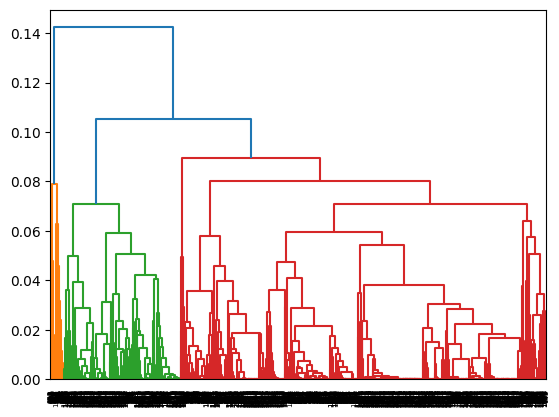

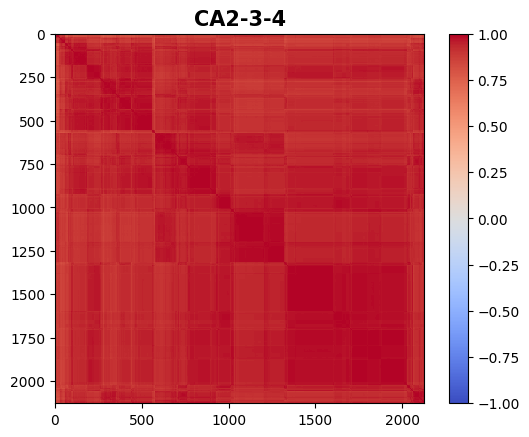

[1 1 1 ... 1 1 1]


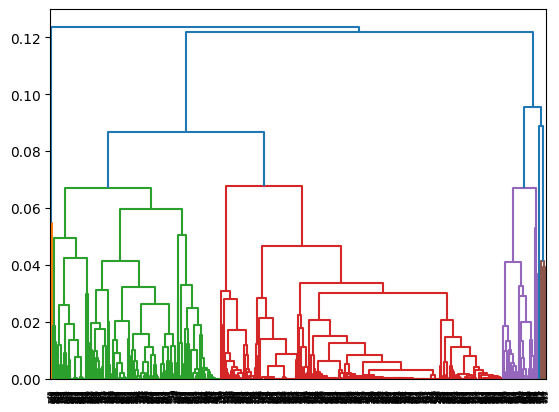

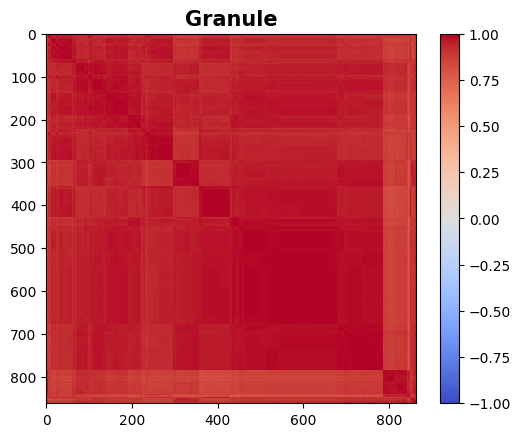

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

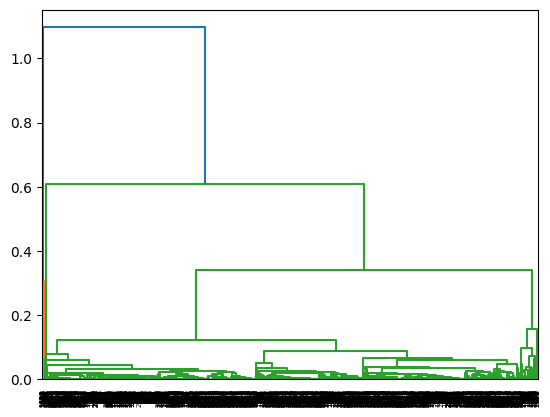

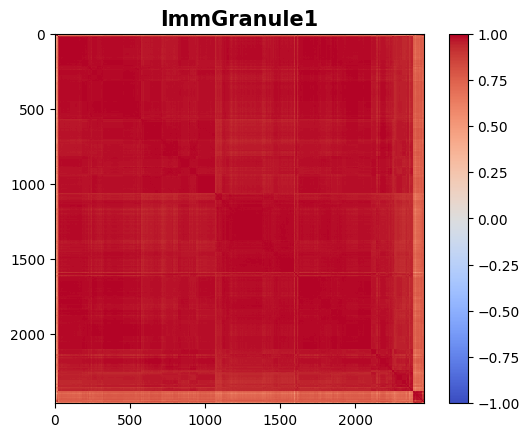

[4 4 4 ... 4 4 4]


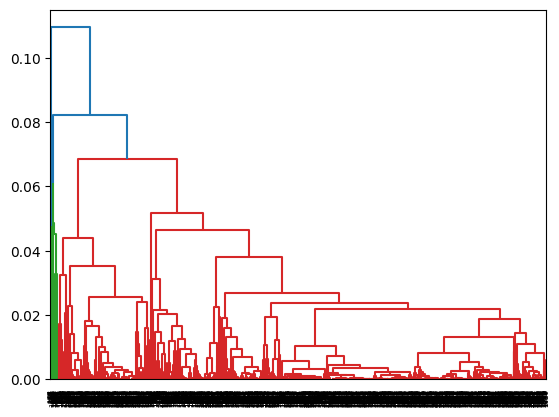

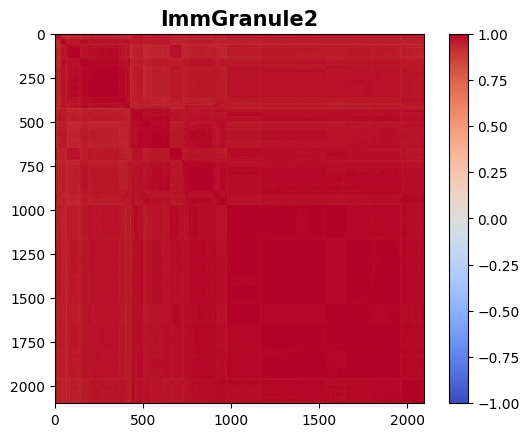

[1 1 1 ... 1 1 1]


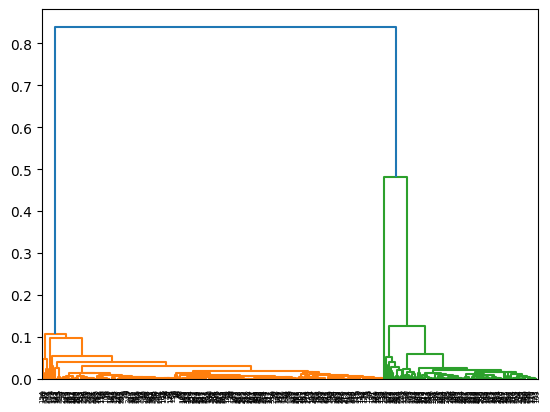

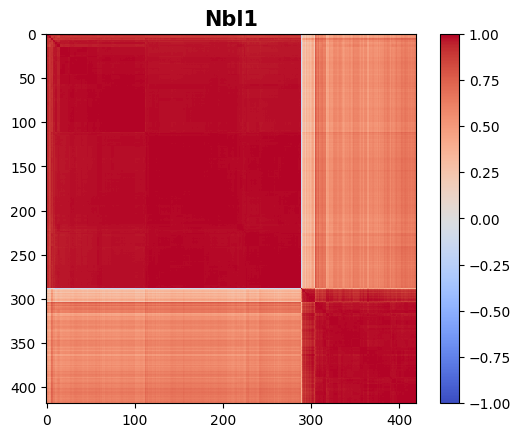

[1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 2 2 1 2 1 2 1 2 3 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 2
 1 1 2 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 1
 1 1 1 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 1 1 1 2 1 1 1
 1 2 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1
 2 1 1 1 2 2 1 2 1 2 1 1 2 1 1 1 1 2 1 2 2 1 1 1 1 2 2 1 2 1 1 2 1 2 2 1 1
 1 1 2 1 1 1 1 2 1 2 1 2 2 1 2 2 2 2 2 2 1 2 2 1 1 1 1 2 2 2 1 1 2 1 1 1 1
 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 1 2 1 1 1 2 2 2 1 2 2 1 1 1 1 1 2 1 2 2 2 1
 1 1 1 1 1 1 2 2 1 1 1 2 2 2 1 1 2 2 1 2 1 1 1 1 2 1 2 1 2 1 1 2 2 2 1 1 1
 2 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 2 2 1 1 1 2 1 2
 2 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 2 2 2 2 1 2 2 2 2 2 1 1 1 2 2 2 1 1 1 1
 2 2 2 1 1 1 2 1 2 1 1 1]


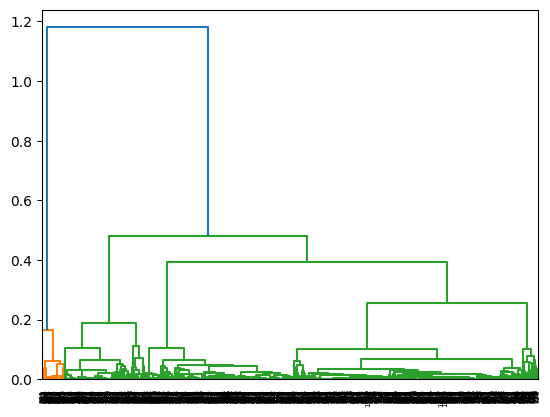

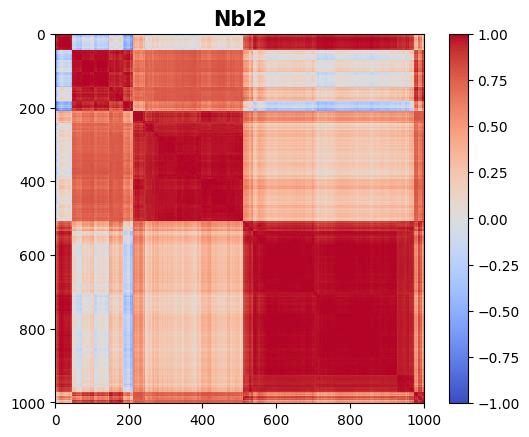

[3 4 3 ... 4 4 4]


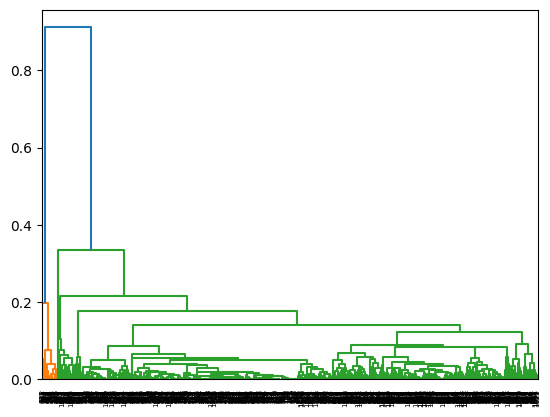

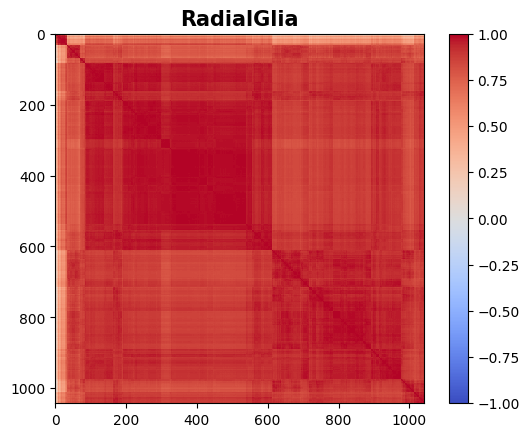

[2 2 2 ... 2 2 2]


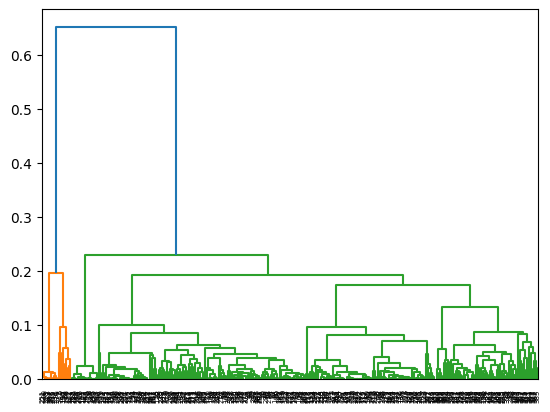

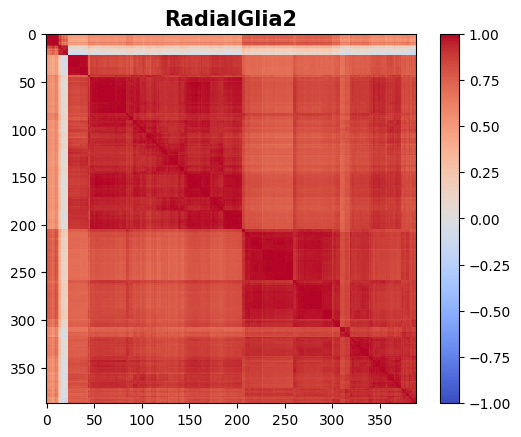

[2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [123]:
###After optimize the cosdistance. cluster threshold is t
from matplotlib.colors import Normalize
TT = {}
for i in range(len(categories)):
    cl_cat = categories[i]
    vec_corr = eigenvec[cl_cat]@eigenvec[cl_cat].T
    
    Z=linkage((1-vec_corr)[np.triu_indices(vec_corr.shape[0],k=1)],method='weighted')#method='weighted')
    dg=dendrogram(Z)
    #X_re= X[:,dg['leaves']]#X_re reorder X by clustering
    plt.show()
    
    vec_corr_re = vec_corr[dg['leaves'],:][:,dg['leaves']]
    plt.imshow(vec_corr_re, aspect='equal', cmap=plt.cm.coolwarm, interpolation='nearest',norm=Normalize(-1,1))
    plt.title(categories[i],fontsize=15,weight='bold')
    plt.colorbar()

    plt.savefig(result_path+f'Corr_new of {categories[i]}.png')
    plt.show()

    # xcos = np.linspace(0,1,100)
    # plt.plot(xcos,gaussian_kde(vec_corr.flatten())(xcos))
    # plt.title(categories[i],fontsize=15,weight='bold')
    # plt.show()
    
    T = fcluster(Z, t=1 - 0.75, criterion='distance')
    print(T)

    TT[categories[i]] = T

10

cluster number of CA 5
num of 1 type in CA: 17
num of 2 type in CA: 23
num of 3 type in CA: 2152
num of 4 type in CA: 66
num of 5 type in CA: 40

cluster number of CA1-Sub 3
num of 1 type in CA1-Sub: 1662
num of 2 type in CA1-Sub: 1
num of 3 type in CA1-Sub: 1

cluster number of CA2-3-4 1
num of 1 type in CA2-3-4: 2129

cluster number of Granule 1
num of 1 type in Granule: 863

cluster number of ImmGranule1 5
num of 1 type in ImmGranule1: 9
num of 2 type in ImmGranule1: 9
num of 3 type in ImmGranule1: 3
num of 4 type in ImmGranule1: 2357
num of 5 type in ImmGranule1: 82

cluster number of ImmGranule2 1
num of 1 type in ImmGranule2: 2099

cluster number of Nbl1 3
num of 1 type in Nbl1: 289
num of 2 type in Nbl1: 129
num of 3 type in Nbl1: 1

cluster number of Nbl2 5
num of 1 type in Nbl2: 46
num of 2 type in Nbl2: 165
num of 3 type in Nbl2: 298
num of 4 type in Nbl2: 463
num of 5 type in Nbl2: 31

cluster number of RadialGlia 3
num of 1 type in RadialGlia: 33
num of 2 type in Radial

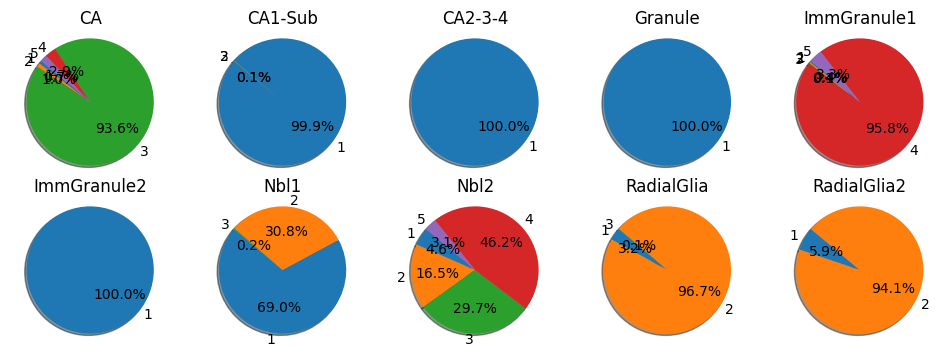

In [124]:
print(len(categories))
fig, axs = plt.subplots(2, 5,figsize = (12,4))
k = 0
for i in categories:
    print('')
    print(f'cluster number of {i}',len(set(TT[i])))
    for j in set(TT[i]):
        print(f'num of {j} type in {i}:',np.sum(TT[i] == j))
    axs[k//5,k%5].pie([np.sum(TT[i] == j) for j in set(TT[i])], labels=set(TT[i]), autopct='%1.1f%%', shadow=True, startangle=140)
    axs[k//5,k%5].axis('equal')  # 确保饼图是圆形的
    axs[k//5,k%5].set_title(f'{i}')
    k+=1
plt.savefig(result_path+'pie_eigenvector.png')
plt.show()


In [98]:
np.max(Z[:,2])

0.6518687258814513

plot the new vector

In [125]:
def plot3d(x1,x2,x3,color,color_bar_name='color_bar',save_name='3d.png'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
    cmap = plt.colormaps['Spectral']
    sc = ax.scatter(x1, x2, x3,  s=10, c=color,alpha=0.8,cmap=cmap)
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label(color_bar_name)
    plt.savefig(result_path+save_name)
    plt.show()

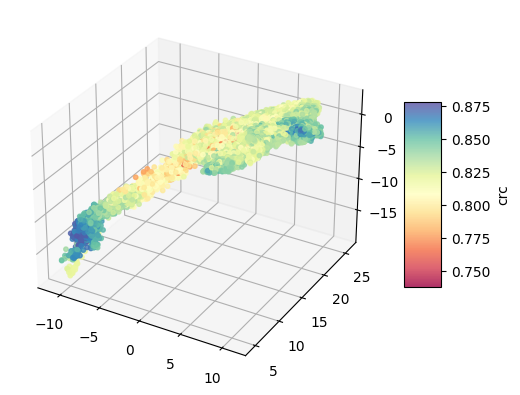

In [130]:
###CRC ON EMBEDDIGN
if L>2:
    max1,max2,max3 = np.argsort(np.mean(sigma_learned**2,axis=0))[-3:]
    plot3d(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],
       color=crc_smooth,color_bar_name='crc',save_name=f'cl on embedding{K}_{L}.png')

In [246]:
colors = [
    ('red', '#FF0000'),
    ('green', '#00FF00'),
    ('blue', '#0000FF'),
    ('black', '#000000'),
    ('lime', '#FFFFFF'),
    ('yellow', '#FFFF00'),
    ('cyan', '#00FFFF'),
    ('magenta', '#FF00FF'),
    ('orange', '#FFA500'),
    ('purple', '#800080'),
    ('gray', '#808080')
]

In [387]:
newvec={}
startvec={}
color_cl = {}
k=0
for i in categories:
    newvec[i] ,startvec[i] = [],[]
    color_cl[i] = colors[k][0]
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        newvec[i].append(cell_i + 0.1*vec_j)
        startvec[i].append(cell_i)

In [249]:
color_cell = []
for i in range(len(X)):
    color_cell.append(color_cl[clusters[i]])

CA (tensor([21.5710,  0.5977,  6.1716, 11.2810, -1.8681,  6.0983],
       grad_fn=<ViewBackward0>), tensor([38.4097, 37.0374, 12.5206, 31.5070, 37.5843, 35.6754],
       grad_fn=<AddBackward0>))
CA (tensor([21.6513,  0.6024,  6.2177, 11.3413, -1.8535,  6.1555],
       grad_fn=<ViewBackward0>), tensor([38.5029, 37.1690, 12.5482, 31.5523, 37.7120, 35.8507],
       grad_fn=<AddBackward0>))
CA (tensor([21.6184,  0.6019,  6.2285, 11.3216, -1.8694,  6.1598],
       grad_fn=<ViewBackward0>), tensor([38.4525, 37.1355, 12.4355, 31.4995, 37.6537, 35.8080],
       grad_fn=<AddBackward0>))
CA (tensor([21.6002,  0.5994,  6.2156, 11.3091, -1.8682,  6.1498],
       grad_fn=<ViewBackward0>), tensor([38.4357, 37.0990, 12.4624, 31.4915, 37.6366, 35.7558],
       grad_fn=<AddBackward0>))
CA (tensor([21.6122,  0.6000,  6.2238, 11.3188, -1.8657,  6.1600],
       grad_fn=<ViewBackward0>), tensor([38.4477, 37.1172, 12.4649, 31.4948, 37.6539, 35.7835],
       grad_fn=<AddBackward0>))
CA1-Sub (tensor([21.1483,

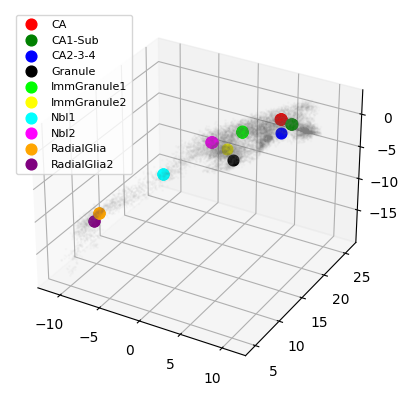

In [402]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
cmap = plt.colormaps['Spectral']
ax.scatter(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],c='grey',s=1,alpha=0.02)
for i in categories:
    k=0
    for j in newvec[i]:
        embed_j = encoder(torch.tensor(j.astype(np.float32)))
        embed_j_mu = embed_j[0].detach().numpy()
        print(i,embed_j)
        ax.scatter(embed_j_mu[max1], embed_j_mu[max2], embed_j_mu[max3], c=color_cl[i], s=60,alpha=1,cmap=cmap,
                   label = i if k==0 else None)
        k+=1
plt.legend(loc='upper left', fontsize=8)
plt.savefig(result_path+'3d_eigenvector.png')
plt.show()

In [ ]:
####cluster内整体正负号调整
newvec={}
k=0
for i in categories:
    newvec[i]  = []
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        if i in ['Nbl2','ImmGranule2']:
            vec_j = -vec_j
        newvec[i].append(cell_i + 0.1*vec_j)
    newvec[i] = np.array(newvec[i])

In [ ]:
import umap
trans = umap.UMAP(n_neighbors=20, random_state=42).fit(X)

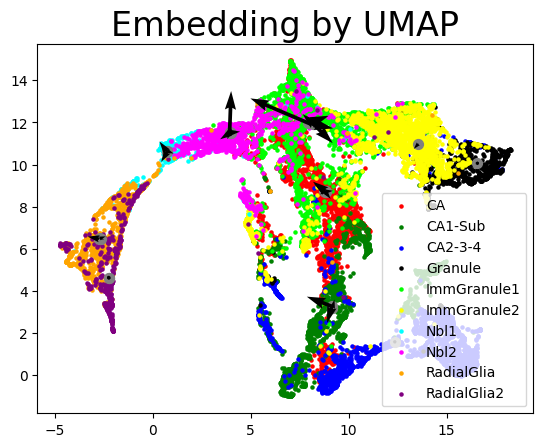

In [406]:
np.random.seed(42)
for i in categories:
    plt.scatter(trans.embedding_[clusters==i, 0], trans.embedding_[clusters==i, 1], s= 5,c = color_cl[i],
                cmap='Spectral',label=f'{i}')
for i in newvec:
    start_embedding = trans.transform(np.vstack(startvec[i]))
    test_embedding = trans.transform(np.vstack(newvec[i]))
    plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
    plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
               test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
               scale=1)
plt.title('Embedding by UMAP', fontsize=24)
plt.legend(loc='lower right')
plt.savefig(result_path+'umap_eigenvector.png')
plt.show()

(2, 14366)

In [375]:
########machine learning for TSNE
#------use a simple neural network to study dmu/dt and dsigma/dt

model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(X.astype(np.float32))
x_out=torch.tensor(np.vstack((X_plt,Y_plt)).T.astype(np.float32))
# Train the model
for epoch in range(300):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    if epoch% 10 == 9:
        print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


9 tensor(55.0290, grad_fn=<MseLossBackward0>)
19 tensor(26.4226, grad_fn=<MseLossBackward0>)
29 tensor(16.0115, grad_fn=<MseLossBackward0>)
39 tensor(10.9295, grad_fn=<MseLossBackward0>)
49 tensor(9.2675, grad_fn=<MseLossBackward0>)
59 tensor(8.2384, grad_fn=<MseLossBackward0>)
69 tensor(7.7344, grad_fn=<MseLossBackward0>)
79 tensor(7.3966, grad_fn=<MseLossBackward0>)
89 tensor(7.1551, grad_fn=<MseLossBackward0>)
99 tensor(6.9703, grad_fn=<MseLossBackward0>)
109 tensor(6.8163, grad_fn=<MseLossBackward0>)
119 tensor(6.7154, grad_fn=<MseLossBackward0>)
129 tensor(6.6372, grad_fn=<MseLossBackward0>)
139 tensor(6.5240, grad_fn=<MseLossBackward0>)
149 tensor(6.4170, grad_fn=<MseLossBackward0>)
159 tensor(6.3208, grad_fn=<MseLossBackward0>)
169 tensor(6.2351, grad_fn=<MseLossBackward0>)
179 tensor(6.1645, grad_fn=<MseLossBackward0>)
189 tensor(6.1006, grad_fn=<MseLossBackward0>)
199 tensor(6.0386, grad_fn=<MseLossBackward0>)
209 tensor(5.9814, grad_fn=<MseLossBackward0>)
219 tensor(6.0911, g

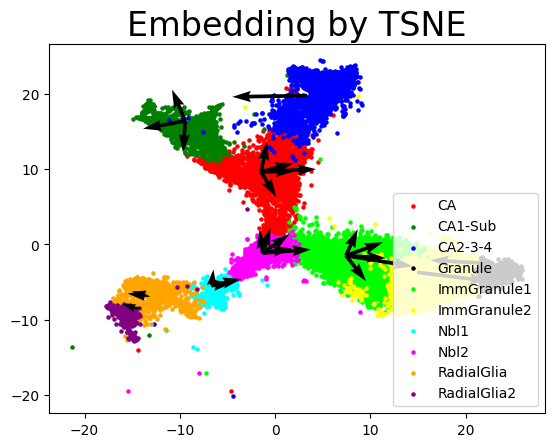

In [404]:
np.random.seed(42)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],
                cmap='Spectral',label=f'{i}')
for i in newvec:
    start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
    test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
    #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
    plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
               test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
               scale=0.3)
plt.title('Embedding by TSNE', fontsize=24)
plt.legend(loc='lower right')
plt.savefig(result_path+'TSNE_eigenvector.png')
plt.show()